In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

# **Preparing the Data**
The CIFAR-10 and CIFAR-100 datasets are famous classification datasets. The first version contains 60,000 `32x32` images from 10 different classes, and the second contains 60,000 `32x32` images from 100 different classes. In this notebook and the next ones for this chapter, we will build and train models to deal with CIFAR-100

Listing the datasets available

In [2]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'emnist', 'eraser_multi_r

We select "cifar100" dataset, let the module download it, and display its meta-information

In [3]:
cifar100_builder = tfds.builder('cifar100')
cifar100_builder.download_and_prepare()
print(cifar100_builder)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteBHHVY1/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteBHHVY1/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [4]:
cifar100_builder.info

tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {

Access the class names

In [5]:
print(cifar100_builder.info.features['label'].names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

CIFAR-100 images can also be classified among 20 coarser classes

In [6]:
print(cifar100_builder.info.features['coarse_label'].names)

['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


## **Input Pipeline Preparation**

We have our training and testing dataset availabel. We can now explicitly define the input pipeline for the models we will train:

In [7]:
import math

# Some hyper-parameters:
input_shape = [224, 224, 3]  # we will resize the input images to this shape
batch_size = 64  # images per batch (reduce/increase according to the machine's capability)
num_epochs = 10  # max number of training epochs

# Train/val datasets:
train_cifar_dataset = cifar100_builder.as_dataset('train')
val_cifar_dataset = cifar100_builder.as_dataset('test')

# Num of classes:
num_classes = cifar100_builder.info.features['label'].num_classes

# Num of images:
num_train_imgs = cifar100_builder.info.splits['train'].num_examples
num_val_imgs = cifar100_builder.info.splits['test'].num_examples

In [8]:
print('Training dataset instance: {}'.format(train_cifar_dataset))

Training dataset instance: <PrefetchDataset shapes: {coarse_label: (), id: (), image: (32, 32, 3), label: ()}, types: {coarse_label: tf.int64, id: tf.string, image: tf.uint8, label: tf.int64}>


Iterate over the samples epochs times and to shuffle them before returning them:

In [9]:
train_cifar_dataset = train_cifar_dataset.repeat(num_epochs).shuffle(10000)

We also wanna pre-process the data itself, resizing the images, ignoring the coarser labels, and optionally applying some radom *augmentations* to the images.

We thus implement a function pre-processing the samples accordingly, and passed it to the `tf.data.Dataset` instance:

In [10]:
def _prepare_data_fn(features, input_shape, augment): 
  """
  Resize image to expected dimensions, and opt. apply some random transformations.
  Args:
    features: Data
    input_shape: Shape expected by the models (image will be resized accordingly)
    augment: Flag to apply some random augmentations to the images.
  :return: Augmented images, labels
  """
  inptu_shape = tf.convert_to_tensor(input_shape)

  # Tensorflow-Dataset returns batches as feature dictionaries, expected by Estimators.
  # To train Keras models, it is more straightforward to return the batch content as tuples:
  image = features['image']
  label = features['label']
  # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  if augment:
    # Randomly applied horizontal flip:
    image = tf.image.random_flip_left_right(image)

    # Random B/S changes:
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Keeping pixel values in check
    image = tf.clip_by_value(t=image, clip_value_min=0.0, clip_value_max=1.0)

    # Random resize and random crop back to expected size:
    random_scale_factor = tf.random.uniform([], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor,
                            tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor,
                           tf.int32)
    scaled_shape = tf.stack([scaled_height, scaled_width])
    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)
  else:
    image = tf.image.resize(image, input_shape[:2])

  return image, label

In [11]:
import functools 

# Setting fixed args for function
prepare_data_fn_for_train = functools.partial(_prepare_data_fn, input_shape=input_shape,
                                              augment=True)
train_cifar_dataset = train_cifar_dataset.map(prepare_data_fn_for_train, num_parallel_calls=4)
# We also ask the dataset to batch the samples:
train_cifar_dataset = train_cifar_dataset.batch(batch_size)

# Improve time performance
train_cifar_dataset = train_cifar_dataset.prefetch(1)

Similarly, we further prepare the validation dataset (though not shuffling or augment it):

In [12]:
prepare_data_fn_for_val = functools.partial(_prepare_data_fn, input_shape=input_shape,
                                            augment=False)
val_cifar_dataset = (val_cifar_dataset.repeat()
                                      .map(prepare_data_fn_for_val, num_parallel_calls=4)
                                      .batch(batch_size)
                                      .prefetch(1))
                                      
                                      
                                      

We now have our datasets ready to be iterated over for training.

These objects are indeed compatible with Keras methods such as `model.fit()`. However, to work properly together, we need to specify to Keras how many batches per epoch such Dataset objects have (when calling `model.fit()`, with the parameters `steps_per_epoch` for the number of training batches, and `validation_steps` for the validation ones):

In [13]:
# `math.ceil()` rounds a number UP to the nearest integer'
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

# **Implementing ResNet with Keras**

We will opt for the Keras API to speed up the implementation. By the end of this section, we will have a *ResNet builder* tool, able to instantiate any of the usual residual networks (ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-102, etc.)

**Note**: We will use Keras Functional API to implement the model. This API can also be used in a more *object-oriented* manner. In the Appendix of this notebook, we propose a second implementation of ResNet from scratch, following this paradigm. 

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Conv2D,
                                     MaxPooling2D, GlobalAveragePooling2D, 
                                     BatchNormalization, add, AveragePooling2D)
import tensorflow.keras.regularizers as regularizers

## **Implementing the Residual Blocks**

In order to implement such a model-builder function, able to generate networks of various sizes, we need to make the TesNet implementation modular. Therefore, we will implement the ResNet main components, the residual blocks, in a modular way, so that we can chain them indefinitely.

The residual blocks are composed of:

* One *residual* branch, applying a 3x3 convolution to the input, followed by batch normalization and ReLu activation.

* One *shortcut* branch, directly forwarding the input without modification, or only applying a 1x1 convolution to adapt the input volume in case it changed in the other branch.

* One *merge* operation, performing an element-wise addition between the results of the two branches.

We will now implement each of this sub-modules. First, let us wrap the conv-batchnorm-relu stack of layers into a single function we could reuse at will:

In [15]:
def _res_conv(filters, kernel_size=3, padding='same', strides=1, use_relu=True,
              use_bias=False, name='cbr', kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(1e-4)):
  """
  Return a layer block chaining conv, batchnorm and relu activation.
  Args:
    filters: Num of filters.
    kernel_size: Kernel size.
    padding: Convolution padding.
    strides: Convolution strides.
    use_relu: Flag to apply ReLy activation at the end.
    use_bias: Flag to use bias or not in Conv layer.
    name: Name suffix for the layers.
    kernel_initializer: Kernel initialization method name.
    kernal_regularizer: Kernel regularizer.
  :return: Callable layer block.
  """

  def layer_fn(x):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                  padding=padding, use_bias=use_bias, name=name + '_c',
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=kernel_regularizer)(x)
    res = BatchNormalization(axis=-1, name=name + '_bn')(conv)
    if use_relu:
      res = Activation('relu', name=name + '_r')(res)
    return res
    
  return layer_fn

Thanks to this function, we can add this stack of 3 layers to our network simply with ```x = _conv_batchnorm_relu(**params)(x)```. We are therefore almost done convering the implementation of the 1st branch in the residual blocks.

Now we will deal with the *shortcut* branch. For simplicity, we will wrap its operation along with the following *merge* operation since. Indeed, this function already needs to receive as parameters both the input tensor and the result of the *residual* branch to the *shortcut* one, so that it can compare the tensors's shapes to check if the dimensions were changed. If so, a 1x1 convolution is applied to resize the input tensor accordingly before the *merge*. Otherwise, the input tensor is left untouched. And since the function has both the *residual* and the *shortcut* results, it is a matter of a single line to do the *merge* right away:

In [16]:
def _merge_with_shortcut(kernel_initializer='he_normal', 
                         kernel_regularizer=regularizers.l2(1e-4), name='block'):
  """
  Return a layer block which merge an input tensor and the corresponding residual
  ouput tensor from another branch.
  Args:
    kernel_initializer: Kernal initialization method name.
    kernel_regularizer: Kernel regularizer.
    name: Name suffix for the layers.
  :return: Callable layer block.
  """
  
  def layer_fn(x, x_residual):
    # We check if `x_residual` was scaled down. If so, we scale `x` accordingly 
    # with a 1x1 conv:
    x_shape = tf.keras.backend.int_shape(x)
    x_residual_shape = tf.keras.backend.int_shape(x_residual)

    if x_shape == x_residual_shape:
        x_shortcut = x
    else:
      strides = (
          int(round(x_shape[1] / x_residual_shape[1])),  # vertical stride
          int(round(x_shape[2] / x_residual_shape[2]))  # horizontal stride
      )
      x_residual_channels = x_residual_shape[3]
      x_shortcut = Conv2D(filters=x_residual_channels, kernel_size=1, strides=strides,
                 padding='valid', name=name + '_shortcut', 
                 kernel_initializer=kernel_initializer,
                 kernel_regularizer=kernel_regularizer)(x)

    merge = add([x_shortcut, x_residual])

    return merge

  return layer_fn

We now have everything to create complete residual blocks:

In [17]:
def _residual_block_basic(filters, kernel_size=3, strides=1, use_bias=False, 
                          kernel_initializer='he_normal', name='res_basic',
                          kernel_regularizer=regularizers.l2(1e-4)):
  """
  Return a basic residual layer block.
  Args:
    filters: Num of filters.
    kernel_size: Kernel size.
    strides: Convolution strides.
    use_bias: Flag to use bias or not in Conv layer.
    kernel_initializer: Kernel initialization method name.
    kernel_regularizer: Kernel regularizer.
    name: Name suffix for the layers.
  :return: Callable layer block.
  """

  def layer_fn(x):
    conv1 = _res_conv(filters=filters, kernel_size=kernel_size, strides=strides,
                   padding='same', use_bias=use_bias, name=name + 'cbr_1',
                   kernel_initializer=kernel_initializer, use_relu=True,
                   kernel_regularizer=kernel_regularizer)(x)
    x_residual = _res_conv(filters=filters, kernel_size=kernel_size, strides=1,
                   padding='same', use_bias=use_bias, name=name + 'cbr_2',
                   kernel_initializer=kernel_initializer, use_relu=False,
                   kernel_regularizer=kernel_regularizer)(conv1)
    merge = _merge_with_shortcut(kernel_initializer=kernel_initializer,
                                 kernel_regularizer=kernel_regularizer,
                                 name=name)(x, x_residual)
    merge = Activation('relu')(merge)

    return merge

  return layer_fn

With this implementation, we can easily chain residual blocks, e.g.:

```
# x = previous layer
x = _residual_block_basic(filters=64, strides=2)(x)
x = _residual_block_basic(filters=64, strides=1)(x)
# ...
```

Before building our complete model, we will however implement a different type of residual blocks. Indeed, this basic block becomes quit costly in terms of computations the deeper the networks goes. In their paper introducing ResNet, He et al. proposed a second type of blocks to replace the basic ones for deeper architectures. To keep in check the number of computations, those blocks make use of the *bottleneck* technique we presented with the Inception models. The two 3x3 convolutions are replaced by a 3x3 convolution surrounded by 1x1 ones as follow:




In [18]:
def _residual_block_botteneck(filters, kernel_size=3, strides=1, use_bias=False,
                              kernel_initializer='he_normal', name='res_bottleneck',
                              kernel_regularizer=regularizers.l2(1e-4)):
  """
  Return a residual layer block with bottleneck, recommended for deep ResNet (depth > 34).
  Args:
    filters: Num of filters.
    kernel_size: Kernel size.
    strides: Convolution strides.
    use_bias: Flag to use bias or not in Conv layer.
    kernel_initializer: Kernel initialization method name.
    kernel_regularizer: Kernel regularizer.
    name: Name suffix for the layers.
  :return: Callable layer block.
  """

  def layer_fn(x):
    x_bottleneck = _res_conv(filters=filters, kernel_size=1, strides=strides,
                             padding='valid', use_bias=use_bias, name=name + 'cbr_1',
                             kernel_initializer=kernel_initializer, use_relu=True,
                             kernel_regularizer=kernel_regularizer)(x)
    x_conv = _res_conv(filters=filters, kernel_size=kernel_size, strides=1,
                       padding='same', use_bias=use_bias, name=name + 'cbr_2',
                       kernel_initializer=kernel_initializer, use_relu=True,
                       kernel_regularizer=kernel_regularizer)(x_bottleneck)
    x_residual = _res_conv(filters=filters * 4, kernel_size=1, strides=1,
                           padding='valid', use_bias=use_bias, name=name + 'cbr_3',
                           kernel_initializer=kernel_initializer, use_relu=False,
                           kernel_regularizer=kernel_regularizer)(x_conv)
    merge = _merge_with_shortcut(kernel_regularizer=kernel_regularizer,
                                 kernel_initializer=kernel_initializer,
                                 name=name)(x, x_residual)
    merge = Activation('relu')(merge)

    return merge

  return layer_fn

## **Chaining Blocks into Modular Networks**

We saw that residual blocks in usual ResNet models are chained according to a specify pattern. Every `b` blocks, we find a residual block with `strides = 2` reducing the spatial dimensionality (followed by `b - 1` blocks with `strides = 1`). It will make the rest of the implementation much easier if we wrap the instantiation of these `b` blocks togerther:

In [19]:
def _residual_macroblock(block_fn, filters, repetitions=2, kernel_size=3, 
                         strides_1st_block=2, use_bias=False, name='res_macroblock',
                         kernel_initializer='he_normal', 
                         kernel_regularizer=regularizers.l2(1e-4)):
  """
  Return a layer block, composed of a repetition of `N` residual blocks.
  Args:
    block_fn: Block layer method to be used.
    repetitions: Number of times the block should be repeated inside.
    filters: Number of filters.
    kernel_size: Kernel size.
    strides_1st_block: Convolution strides for the 1st block.
    use_bias: Flag to use bias or not in Conv layer.
    kernel_initializer: Kernel initialization method name.
    kernal_regularizer: Kernel regularizer.
    name: Name suffix for the layer
  :return: Callable layer block.
  """

  def layer_fn(x):
    for repet in range(repetitions):
      strides = strides_1st_block if repet == 0 else 1
      block_name = '{}_{}'.format(name, repet)
      x = block_fn(filters=filters, kernel_size=kernel_size, strides=strides,
                       use_bias=use_bias, kernel_initializer=kernel_initializer,
                       kernel_regularizer=kernel_regularizer, name = block_name)(x)
    
    return x

  return layer_fn

As before, the function we just wrote makes it possible to easily chain these macro-blocks together into a network as deep as we wish! It is now just matter of adding the 3 layers preceeding the residual blocks (a 7x7 convolution and a max-pooling) as well as the final layers leading to the predictions (avg-pooling and FC):

In [20]:
def ResNet(input_shape, num_classes=1000, block_fn=_residual_block_basic,
           repetitions=(2, 2, 2, 2), use_bias=False, 
           kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-4)):
  """
  Build a ResNet model for classification.
  Args:
    input_shape: Input shape (e.g. (224, 224, 3)).
    num_classes: Number of classes to predict.
    block_fn: Block layer method to be used.
    repetitions: List of repetitions for each macro-blocks the network should contain.
    use_bias: Flag to use bias or not in Conv layer.
    kernel_initializer: Kernel initialization method name.
    kernel_regularizer: Kernel regularizer.
  :return: ResNet model.
  """

  # Input and 1st layers:
  input = Input(shape=input_shape)
  conv = _res_conv(filters=64, kernel_size=7, strides=2, use_relu=True, 
                   use_bias=use_bias, kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer)(input)
  maxpool = MaxPooling2D(pool_size=3, strides=2, padding='same')(conv)

  # Chain of residual blocks:
  filters = 64
  strides = 2
  res_block = maxpool
  for i, repet in enumerate(repetitions):
    # We dont further reduce the input size for the 1st block (max-pool applied just before):
    block_name = 'block_{}'.format(i)
    block_strides = strides if i != 0 else 1
    res_block = _residual_macroblock(block_fn, filters, repetitions=repet,
                                     strides_1st_block=block_strides, 
                                     use_bias=use_bias, name=block_name,
                                     kernel_initializer=kernel_initializer,
                                     kernel_regularizer=kernel_regularizer)(res_block)
    filters = min(filters * 2, 1024)  # we limit to 1024 filters max

  # Final layers for prediction:
  res_spatial_dim = tf.keras.backend.int_shape(res_block)[1:3]
  avg_pool = AveragePooling2D(pool_size=res_spatial_dim, strides=1)(res_block)
  flatten = Flatten()(avg_pool)
  predictions = Dense(units=num_classes, kernel_initializer=kernel_initializer,
                      activation='softmax')(flatten)

  # Model:
  model = Model(inputs=input, outputs=predictions)

  return model

We have our ResNet-builder function! Playing with the `repetitions` parameter, we can now spawn networks as deep as we want.

With this, we can easily define the classic ResNet models:

In [21]:
def ResNet18(input_shape, num_classes=1000, use_bias=True, 
             kernel_initializer='he_normal', kernel_regularizer=None):
  return ResNet(input_shape=input_shape, num_classes=num_classes, use_bias=use_bias,
                block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
                kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
              

def ResNet34(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
  return ResNet(input_shape=input_shape, num_classes=num_classes, use_bias=use_bias,
                block_fn=_residual_block_basic, repetitions=(3, 4, 6, 3),
                kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
  

def ResNet50(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
  # Note: ResNet50 is similar to ResNet34, with the basic blocks replaced by
  # bottleneck ones
  return ResNet(input_shape=input_shape, num_classes=num_classes, use_bias=use_bias,
                block_fn=_residual_block_botteneck, repetitions=(3, 4, 6, 3),
                kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
    

def ResNet101(input_shape, num_classes=1000, use_bias=True,
              kernel_initializer='he_normal', kernel_regularizer=None):
  return ResNet(input_shape=input_shape, num_classes=num_classes, use_bias=use_bias,
                block_fn=_residual_block_bottleneck, repetitions=(3, 4, 23, 3),
                kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
  
def ResNet152(input_shape, num_classes=1000, use_bias=True,
              kernel_initializer='he_normal', kernel_regularizer=None):
  return ResNet(input_shape=input_shape, num_classes=num_classes, use_bias=use_bias,
                block_fn=_residual_block_botteneck, repetitions=(3, 8, 36, 3),
                kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)

## **Demonstrating with ResNet50**

For the rest of this notebook, we will opt. for ResNet50.

Note that for their ImageNet experiments, the ResNet authors used 224x224 images as input. In order to have a similar network, we will consider the same input dimensions (adding a proper scaling operation to our input pipeline, to resize the Tiny-ImageNet samples from 64x64 to 224x224):

In [22]:
resnet50 = ResNet50(input_shape=input_shape, num_classes=num_classes)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
cbr_c (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
cbr_bn (BatchNormalization)     (None, 112, 112, 64) 256         cbr_c[0][0]                      
__________________________________________________________________________________________________
cbr_r (Activation)              (None, 112, 112, 64) 0           cbr_bn[0][0]                     
______________________________________________________________________________________________

# **Classifying Images with ResNet**

We will now apply our ResNet50 model to the classification of the CIFAR-100 pictures.

## **Training the Network**

To imitate the ImageNet experiments, we will add the top-5 accuracy metrics. Conveniently, TensorFlow and Keras already provides multiple predefined losses and metrics:

In [23]:
optimizer = tf.keras.optimizers.Adam()

accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top_5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                 metrics=[accuracy_metric, top_5_accuracy_metric])

We have been using various pre-defined callbacks. This time, we will implement our own, inheriting from the abstract `Callback` class. This class defines an interface composed of several methods which will be called by Keras along the training (before each epoch, befor each batch iteration, after each batch iteration, etc.).

For demonstration and to have more concise logs (since this notebook is quite long already), we will implement a callback printing some results only every `log_frequency` epochs, with some fancier styling:

In [32]:
# Setting some variable to format the logs
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

class SimpleLogCallback(tf.keras.callbacks.Callback):
  """
  Keras callback for simple, denser console logs.
  """

  def __init__(self, metrics_dict, num_epochs, log_frequency=1, 
               metric_string_template='{0}[[name]]{2} = {1}{[[value]]:.4f}{2}'):
    """
    Initialize the Callback.
    Args:
      metrics_dict: Dictionary containing mappings for metrics names/keys 
                    e.g. {"accuracy": "acc", "val. accuracy": "val_acc"}
      num_epochs: Number of training epochs.
      log_frequency: Log frequency (in epochs).
      metric_string_template: (opt.) String template to print each metric.
    """

    super().__init__()
    self.metrics_dict = collections.OrderedDict(metrics_dict)
    self.num_epochs = num_epochs
    self.log_frequency = log_frequency

    # We build a format string later print the metrics, 
    # (e.g. "Epoch 0/9: loss = 1.00; val-loss = 2.00")
    log_string_template = 'Epoch {3:2}/{4}: '
    separator = '; '

    i = 5
    for metric_name in self.metrics_dict:
      temp = metric_string_template.replace('[[name]]', metric_name) \
                                   .replace('[[value]]', str(i))
      log_string_template += temp + separator
      i += 1

    # Remove the "; " after the last element:
    log_string_template = log_string_template[:-len(separator)]
    self.log_string_template = log_string_template

  def on_train_begin(self, logs=None):
    print('Training: {}start{}'.format(log_begin_red, log_end_format))

  def on_train_end(self, logs=None):
    print('Training: {}end{}'.format(log_begin_green, log_end_format))

  def on_epoch_end(self, epoch, logs={}):
    if (epoch - 1) % self.log_frequency == 0 or epoch == self.num_epochs:
      values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
      print(self.log_string_template.format(log_begin_bold, log_begin_blue,
                                            log_end_format, epoch, self.num_epochs,
                                            *values))

***Note***: This callback function is added to `keras_custom_callbacks.py`, so we can reuse it in the next notebooks.

We now instantiate and prepare all the callbacks we want to apply to our training:

In [33]:
import collections

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("acc", "acc"), ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), ("v-top5-acc", "val_top5_acc")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs,
                                        log_frequency=2)

In [34]:
model_dir = './models/resnet_from_scratch'
model_file = 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'
callbacks = [tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc', 
                                              restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(os.path.join(model_dir, model_file),
                                                period=5),
             # Log callback:
             callback_simple_log]

We can now compile our model with a classification loss and the desired metrics, before launching the training:

In [35]:
history = resnet50.fit(train_cifar_dataset, epochs=num_epochs, 
                       steps_per_epoch=train_steps_per_epoch,
                       validation_data=(val_cifar_dataset), 
                       validation_steps=val_steps_per_epoch, verbose=0, 
                       callbacks=callbacks)

Training: start
Epoch  1/10: loss = 2.1632; v-loss = 2.1743; acc = 0.4244; v-acc = 0.4260; top5-acc = 0.7425; v-top5-acc = 0.7332
Epoch  3/10: loss = 1.7924; v-loss = 1.9658; acc = 0.5104; v-acc = 0.4867; top5-acc = 0.8106; v-top5-acc = 0.7823


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch  5/10: loss = 1.5073; v-loss = 1.5664; acc = 0.5767; v-acc = 0.5689; top5-acc = 0.8593; v-top5-acc = 0.8399
Epoch  7/10: loss = 1.2856; v-loss = 1.5477; acc = 0.6327; v-acc = 0.5781; top5-acc = 0.8923; v-top5-acc = 0.8465


Epoch  9/10: loss = 1.1202; v-loss = 1.4345; acc = 0.6746; v-acc = 0.6058; top5-acc = 0.9165; v-top5-acc = 0.8711
Training: end


Note that the `history` object returned by `model.fit()` can also be used to plot some of the training metrics:

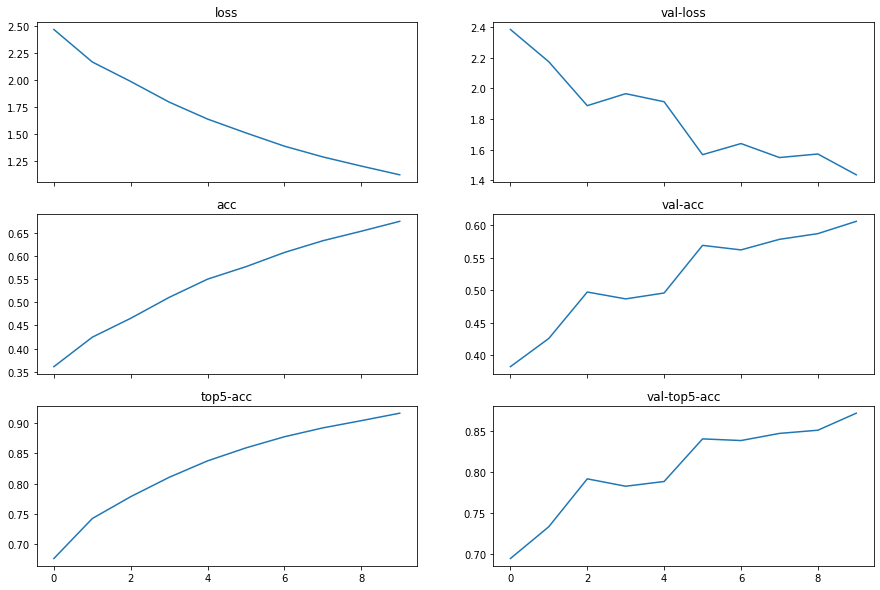

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex='col')  # add parameter `sharey='row'` for a more direct comparison
axs[0, 0].set_title('loss')
axs[0, 1].set_title('val-loss')
axs[1, 0].set_title('acc')
axs[1, 1].set_title('val-acc')
axs[2, 0].set_title('top5-acc')
axs[2, 1].set_title('val-top5-acc')

axs[0, 0].plot(history.history['loss'])
axs[0, 1].plot(history.history['val_loss'])
axs[1, 0].plot(history.history['acc'])
axs[1, 1].plot(history.history['val_acc'])
axs[2, 0].plot(history.history['top5_acc'])
axs[2, 1].plot(history.history['val_top5_acc'])

In [37]:
best_val_acc = max(history.history['val_acc']) * 100
best_val_top5 = max(history.history['val_top5_acc']) * 100

print('Best val acc: {:2.2f}%'.format(best_val_acc))
print('Best val top5: {:2.2f}%'.format(best_val_top5))

Best val acc: 60.58%
Best val top5: 87.11%


## **Predicting with the Network**

Since we know have a complex model, fully implemented and trained by ourselves, we cannot conclude this notebook without at least testing it once on some unseen images.

For that purpose, we first implement some utility functions to load test images (simply as `numpy` arrays), to get the top-t predictions and corresponding labels from the model's outputs, and finally to plot the results:

In [60]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def load_images(img_path, size):
  """
  Load an image ad Numpy array.
  Args:
    img_path: Path of the image.
    size: Target size.
  :return: Image array, normalized between 0 and 1.
  """

  img = img_to_array(load_img(img_path, target_size=size)) / 255.
  return img

def process_predictions(class_probabilities, class_readable_labels, k=5):
  """
  Process a batch of predictions from our estimator.
  Args:
    class_probabilities: Prediction results returned by the Keras classifier for 
                          a batch of data.
    class_readable_labels: List of readable-class labels, for display.
    k: Number or top predictions to consider.
  :return: Readable labels and probabilities for the predicted classes.
  """

  topk_labels, topk_probabilities = [], []
  for i in range(len(class_probabilities)):
    # Getting the top-k predictions:
    topk_classes = sorted(np.argpartition(class_probabilities[i], -k)[-k:])

    # Getting the corresponding labels and probabilities:
    topk_labels.append([class_readable_labels[predicted] for predicted in topk_classes])
    topk_probabilities.append(class_probabilities[i][topk_classes])

  return topk_labels, topk_probabilities

def display_predictions(images, topk_labels, topk_probabilities):
  """
  Plot a batch of predictions.
  Args:
    images: Batch of input images.
    topk_labels: String labels of predicted classes.
    topk_probabilities: Probabilities for each class.
  """

  num_images = len(images)
  num_images_sqrt = np.sqrt(num_images)
  plot_cols = plot_rows = int(np.ceil(num_images_sqrt))

  figure = plt.figure(figsize=(13, 10))
  grid_spec = gridspec.GridSpec(plot_cols, plot_rows)

  for i in range(num_images):
    img, pred_labels, pred_proba = images[i], topk_labels[i], topk_probabilities[i]
    # Shortening the labels to better fit in the plot:
    pred_labels = [label.split(',')[0][:20] for label in pred_labels]

    grid_spec_i = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid_spec[i],
                                                   hspace=0.1)
    
    # Drawing the input images:
    ax_img = figure.add_subplot(grid_spec_i[:2])
    ax_img.axis('off')
    ax_img.imshow(img)
    ax_img.autoscale(tight=True)

    # Plotting a bar chart for the predictions:
    ax_pred = figure.add_subplot(grid_spec_i[2])
    ax_pred.spines['top'].set_visible(False)
    ax_pred.spines['right'].set_visible(False)
    ax_pred.spines['bottom'].set_visible(False)
    ax_pred.spines['left'].set_visible(False)
    y_pos = np.arange(len(pred_labels))
    ax_pred.barh(y_pos, pred_proba, align='center')
    ax_pred.set_yticks(y_pos)
    ax_pred.set_yticklabels(pred_labels)
    ax_pred.invert_yaxis()

  plt.tight_layout()
  plt.show()

***Note***: This utility functions are added to `classification_utils.py` for later use.

We made available several pictures. Let us see how our model fares on these real images!

First we load them:

In [61]:
test_filenames = glob.glob(os.path.join('drive/MyDrive/res', '*'))
test_images = np.asarray([load_images(file, size=input_shape[:2]) for file
                          in test_filenames])
print('Test images: {}'.format(test_images.shape))

Test images: (16, 224, 224, 3)


Finally, we can use our model to predict image per image or batch per batch, and we can use the utility functions we just implemented to display the results:

Predicted class probabilities: (16, 100)


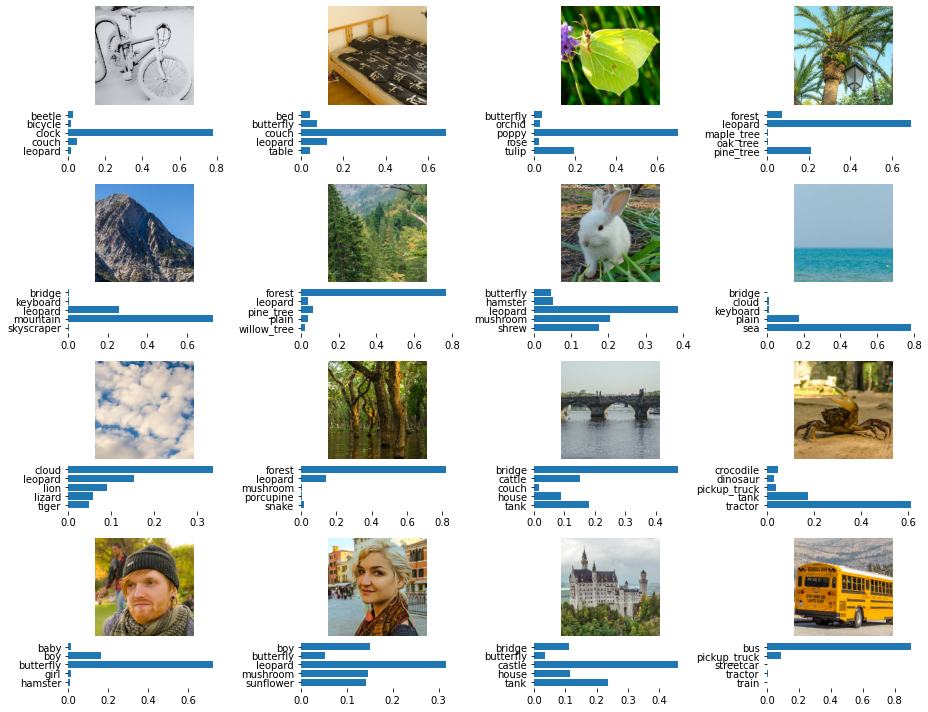

In [62]:
image_batch = test_images[:16]

# Our model was trained on CIFAR images, which originally are 32x32px. We scale
# them up to 224x224px to train our model on, but this means the resulting images
# had important artifacts/low quality.
# Top test on images of same quality, we first resize them to 32x32px, then to the
# expected input size (i.e., 224x224px):
cifar_original_image_size = cifar100_builder.info.features['image'].shape[:2]
image_batch_low_quality = tf.image.resize(image_batch, cifar_original_image_size)
image_batch_low_quality = tf.image.resize(image_batch_low_quality, input_shape[:2])

predictions = resnet50.predict_on_batch(image_batch_low_quality)
print('Predicted class probabilities: {}'.format(predictions.shape))

class_readable_labels = cifar100_builder.info.features['label'].names
top5_labels, top5_probabilities = process_predictions(predictions, class_readable_labels)

display_predictions(image_batch, top5_labels, top5_probabilities)

# **Appendix - Object-Oriented Model Implementation**

In this appendix, we propose a different re-implementation of `ResNet`, following a more `object-oriented` approach.

We rewrite each of the functions to generate layers and blocks as classes, still using Keras Functional API:

In [63]:
class ConvWithBatchNorm(tf.keras.layers.Conv2D):
  """
  Convolutional layer with batch normalization
  """

  def __init__(self, activation='relu', name='convbn', **kwargs):
    """
    Initialize the layer.
    Args:
      activation: Activation function (name or callable).
      name: Name suffix for the sub-layers.
      kwargs: Mandatory and optional parameters of tf.keras.layers.Conv2D.
    """

    self.activation = Activation(activation, 
                                 name=name + '_act') if activation is not None else None
    super().__init__(activation=None, name=name + '_c', **kwargs)
    self.batch_norm = BatchNormalization(axis=-1, name=name + '_bn')

  def call(self, inputs, training=None):
    """
    Call the layer.
    Args:
      inputs: Input tensor to process.
      training: Flag to let TF knows if it is a training iteration or not (this
                will affect the behavior of BatchNorm)
    :return: Convolved tensor
    """

    x = super().call(inputs)
    x = self.batch_norm(x, training=training)
    if self.activation is not None:
      x = self.activation(x)
    return x

In [64]:
import functools

class ResidualMerge(tf.keras.layers.Layer):
  """
  Layer to merge the original tensor and the residual one in residual blocks
  """

  def __init__(self, name='block', **kwargs):
    """
    Initialize the layer
    Args:
      name: Name suffix for the sub-layers.
      kwargs: Optional parameters of tf.keras.layers.Conv2D
    """

    super().__init__(name=name)
    self.shortcut = None
    self.kwargs = kwargs

  def build(self, input_shape):
    x_shape = input_shape[0]
    x_residual_shape = input_shape[1]
    if x_shape[1] == x_residual_shape[1] and \
       x_shape[2] == x_residual_shape[2] and \
       x_shape[3] == x_residual_shape[3]:
       self.shortcut = functools.partial(tf.identity, name=self.name + '_shortcut')
    else:
        strides = (
            int(round(x_shape[1] / x_residual_shape[1])),  # vertial stride
            int(round(x_shape[2] / x_residual_shape[2]))  # horizontal stride
        )
        x_residual_channels = x_residual_shape[3]
        self.shortcut = ConvWithBatchNorm(
            filters=x_residual_channels, kernel_size=(1, 1), strides=strides,
            activation=None, name=self.name + '_shortcut', **self.kwargs
        )

  def call(self, inputs):
    """
    Call the layer.
    Args:
      inputs: Tuples of two input tensor to merge
    :return: Merged tensor
    """

    x, x_residual = inputs
    x_shortcut = self.shortcut(x)
    x_merge = add([x_shortcut, x_residual])
    return x_merge

In [65]:
class BasicResidualBlock(tf.keras.Model):
  """
  Basic residual block.
  """

  def __init__(self, filters=16, kernel_size=1, strides=1, activation='relu',
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4),
               name='res_basic', **kwargs):
    """
    Initialize the layer.
    Args:
      filters: Number of filters.
      kernel_size: Kernel size.
      strides: Convolution strides.
      activation: Activation funciton (name or callable).
      kernel_initializer: Kernel initialization.
      kernel_regularizer: Kernel regularizer.
      name: Name suffix for the sub-layers.
      kwargs: Optional parameters of tf.keras.layers.Conv2D.
    """

    super().__init__(name=name)

    self.conv_1 = ConvWithBatchNorm(filters=filters, kernel_size=kernel_size,
                                    activation=activation, padding='same', 
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer,
                                    strides=strides, name=name + '_cb_1', **kwargs)
    
    self.conv_2 = ConvWithBatchNorm(filters=filters, kernel_size=kernel_size,
                                    activation=None, padding='same', 
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularier=kernel_regularizer,
                                    strides=1, name=name + '_cb_2', **kwargs)
    
    self.merge = ResidualMerge(kernel_initializer=kernel_initializer,
                               kernel_regularizer=kernel_regularizer, name=name)
    
    self.activation = Activation(activation, name=name + '_act')

  def call(self, inputs, training=None):
    """
    Call the block.
    Args:
      inputs: Input tensor to process.
      training: Flag to let TF knows if it is a training iteration or not (this 
                will affect the behavior of BatchNorm)
    :return: Block ouput tensor
    """

    x = inputs
    # Residual path:
    x_residual = self.conv_1(x, training=training)
    x_residual = self.conv_2(x_residual, training=training)

    # Merge residual result with original tensor:
    x_merge = self.merge([x, x_residual])
    x_merge = self.activation(x_merge)
    return x_merge

In [88]:
class ResidualBlockWithBottleneck(tf.keras.Model):
  """
  Residual block with bottleneck, recommended for deep ResNets (depth > 34)
  """

  def __init__(self, filters=16, kernel_size=1, strides=1, activation='relu',
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4),
               name='res_bottleneck', **kwargs):
    """
    Initialize the block.
    Args:
      filters: Number of filters.
      kernel_size: Kernel size.
      strides: Convolution strides.
      activation: Activation function (name or callable).
      kernel_initializer: Kernel initialization method name.
      kernel_regularizer: Kernel regularizer.
      name: Name suffix for the sub-layers.
      kwargs: Optional parameters of tf.keras.layers.Conv2D.
    """

    super().__init__(name=name)

    self.conv_0 = ConvWithBatchNorm(filters=filters, kernel_size=1, 
                                    activation=activation, padding='valid',
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer, 
                                    strides=strides, name=name + '_cb_0', **kwargs)
    
    self.conv_1 = ConvWithBatchNorm(filters=filters, kernel_size=kernel_size,
                                    activation=activation, padding='same', 
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer,
                                    strides=1, name=name + '_cb_1', **kwargs)
    
    self.conv_2 = ConvWithBatchNorm(filters=filters * 4, kernel_size=1, 
                                    activation=None, padding='valid',
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer,
                                    strides=1, name=name + '_cb_2', **kwargs)
    
    self.merge = ResidualMerge(kernel_initializer=kernel_initializer, 
                               kernel_regularizer=kernel_regularizer, name=name)
    
    self.activation = Activation(activation, name=name + '_act')

  def call(self, inputs, training=None):
    """
    Call the layer.
    Args:
      inputs: Input tensor to process.
      training: Flag to let TF knows if it is a training iteration or not (this
                will affect the behavior of BatchNorm)
    :return: Block output tensor
    """

    x = inputs
    # Residual path:
    x_residual = self.conv_0(x, training=training)
    x_residual = self.conv_1(x_residual, training=training)
    x_residual = self.conv_2(x_residual, training=training)

    # Merge residual result with original tensor:
    x_merge = self.merge([x, x_residual])
    x_merge = self.activation(x_merge)
    return x_merge

In [80]:
class ResidualMacroBlock(tf.keras.models.Sequential):
  """
  Macro-block, chaining multiple residual blocks (as a Sequential model)
  """

  def __init__(self, block_class=ResidualBlockWithBottleneck, repetitions=3, 
               filters=16, kernel_size=1, strides=1, activation='relu', 
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4),
               name='res_macroblock', **kwargs):
    """
    Initialize the block.
    Args:
      block_class: Block class to be used.
      repetitions: Number of times the block should be repeated inside.
      filters: Number of filters.
      kernel_size: Kernel size.
      strides: Convolution strides.
      activation: Activation function (name or callable).
      kernel_initializer: Kernel initialization method name.
      kernel_regularizer: Kernel regularizer.
      name: Name suffix for the sub-layers.
      kwargs: Optional parameters of tf.keras.layers.Conv2D.
    """

    super().__init__([block_class(filters=filters, kernel_size=kernel_size, 
                                  activation=activation, strides=strides if i == 0 else 1,
                                  name='{}_{}'.format(name, i), 
                                  kernel_initializer=kernel_initializer,
                                  kernel_regularizer=kernel_regularizer) for i in range (repetitions)],
                     name=name)

In [85]:
class ResNet(tf.keras.models.Sequential):
  """
  ResNet model for classification
  """

  def __init__(self, input_shape, num_classes=1000, 
               block_class=ResidualBlockWithBottleneck, repetitions=(2, 2, 2, 2),
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4),
               name='resnet'):
    """
    Initialize a ResNet model for classification.
    Args:
      input_shape: Input shape (e.g. (224, 224, 3)).
      num_classes: Number or classes to predict.
      block_classes: Block class to be used.
      repetitions: List of repetitions for each macro-blocks the network should contain.
      kernel_initializer: Kernel initialization method name.
      kernel_regularizer: Kernel regularizer.
      name: Model's name.
    :return: ResNet model.
    """

    filters = 64
    strides = 2

    super().__init__(
        # Initial conv + max_pool layers:
        [Input(shape=input_shape, name='input'),
         ConvWithBatchNorm(filters=filters, kernel_size=7, activation='relu', 
                           padding='same', strides=strides, 
                           kernel_initializer=kernel_initializer,
                           kernel_regularizer=kernel_regularizer, name='conv'),
         MaxPooling2D(pool_size=3, strides=strides, padding='same', 
                      name='max_pool')] + \
        # Residual blocks:
        [ResidualMacroBlock(
            block_class=block_class, repetitions=repet, 
            filters=min(filters * (2 ** i), 1024), kernel_size=3, activation='relu',
            strides=strides if i != 0 else 1, name='block_{}'.format(i),
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer
        ) for i, repet in enumerate(repetitions)] + \
        # Final layers leading to classification output:
        [GlobalAveragePooling2D(name='avg_pool'), 
         Dense(units=num_classes, kernel_initializer=kernel_initializer, activation='softmax')],
    name=name)

In [86]:
# Standard ResNet versions:
class ResNet18(ResNet):
  def __init__(self, input_shape, num_classes=1000, name='resnet18', 
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)):
    super().__init__(input_shape, num_classes, block_class=BasicResidualBlock,
                     repetitions=(2, 2, 2, 2), kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)
    

class ResNet34(ResNet):
  def __init__(self, input_shape, num_classes=1000, name='resnet34', 
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)):
    super().__init__(input_shape, num_classes, block_class=BasicResidualBlock, 
                     repetitions=(3, 4, 6, 3), kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)
    

class ResNet50(ResNet):
  def __init__(self, input_shape, num_classes=1000, name='resnet50',
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)):
    super().__init__(input_shape, num_classes, block_class=ResidualBlockWithBottleneck,
                     repetitions=(3, 4, 6, 3), kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)
    

class ResNet101(ResNet):
  def __init__(self, input_shape, num_classes=1000, name='resnet101',
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)):
    super().__init__(input_shape, num_classes, block_class=ResidualBlockWithBottleneck,
                     repetitions=(3, 4, 23, 3), kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)
    

def ResNet152(ResNet):
  def __init__(self, input_shape, num_classes=1000, name='resnet152',
               kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)):
    super().__init__(input_shape, num_classes, block_class=ResidualBlockWithBottleneck,
                     repetitions=(3, 8, 36, 3), kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)

Let instantiate a network and have a look at its structure:

In [87]:
model = ResNet50(input_shape, num_classes)
model.summary(line_length=80, positions=[.5, .85, 1.])

Model: "resnet"
________________________________________________________________________________
Layer (type)                            Output Shape                Param #     
conv_c (ConvWithBatchNorm)              (None, 112, 112, 64)        9728        
________________________________________________________________________________
max_pool (MaxPooling2D)                 (None, 56, 56, 64)          0           
________________________________________________________________________________
block_0 (ResidualMacroBlock)            (None, 56, 56, 256)         220032      
________________________________________________________________________________
block_1 (ResidualMacroBlock)            (None, 28, 28, 512)         1230336     
________________________________________________________________________________
block_2 (ResidualMacroBlock)            (None, 14, 14, 1024)        7129088     
________________________________________________________________________________
block_3 (Res

That is a much more concise summary as the one we printed earlier in the notebook. It may not be as informative though... But since our residual blocks are also `Model` instances, we can check their own summary to obtain as much detail as we wish:

In [76]:
# Summary of the last macro-block:
model.layers[-3].summary(line_length=80, positions=[.5, .85, 1.])

Model: "block_3"
________________________________________________________________________________
Layer (type)                            Output Shape                Param #     
block_3_0 (ResidualBlockWithBottleneck) (None, 7, 7, 2048)          6054912     
________________________________________________________________________________
block_3_1 (ResidualBlockWithBottleneck) (None, 7, 7, 2048)          4471808     
________________________________________________________________________________
block_3_2 (ResidualBlockWithBottleneck) (None, 7, 7, 2048)          4471808     
Total params: 14,998,528
Trainable params: 14,976,000
Non-trainable params: 22,528
________________________________________________________________________________


In [77]:
# Summary of the last block of the last macro-block:
model.layers[-3].layers[-1].summary(line_length=80, positions=[.5, .85, 1.])

Model: "block_3_2"
________________________________________________________________________________
Layer (type)                            Output Shape                Param #     
block_3_2_cb_0_c (ConvWithBatchNorm)    multiple                    1051136     
________________________________________________________________________________
block_3_2_cb_1_c (ConvWithBatchNorm)    multiple                    2361856     
________________________________________________________________________________
block_3_2_cb_2_c (ConvWithBatchNorm)    multiple                    1058816     
________________________________________________________________________________
block_3_2 (ResidualMerge)               multiple                    0           
________________________________________________________________________________
block_3_2_act (Activation)              multiple                    0           
Total params: 4,471,808
Trainable params: 4,465,664
Non-trainable params: 6,144
__________

Both approaches to the Keras Functional API have their own pros and cons.